In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
db = automap_base()
# reflect the tables
db.prepare(engine,reflect = True)

In [6]:
# View all of the classes that automap found
db.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement= db.classes.measurement
station= db.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first().date

'2017-08-23'

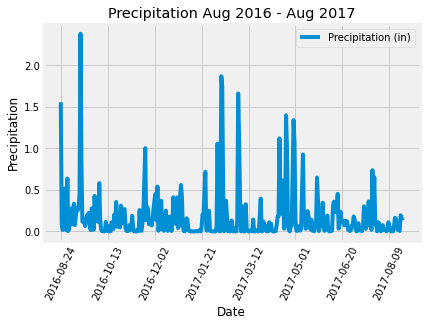

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date= session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
#one_year_ago

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, func.avg(measurement.prcp)).\
                    filter(measurement.date >= one_year_ago).\
                    group_by(measurement.date).all()
#precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precipdf= pd.DataFrame(precip_data, columns=['Date','Precipitation (in)'])
# Sort the dataframe by date
precipdf.sort_values(['Date'])
precipdf.head()




# Use Pandas Plotting with Matplotlib to plot the data
precipdf.plot('Date','Precipitation (in)')
plt.title('Precipitation Aug 2016 - Aug 2017')
plt.xlabel('Date')
plt.ylabel('Precipitation')
#readability
plt.xticks(rotation = 65)
plt.savefig('Resources/precip.png', bbox_inches = 'tight')


In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipdf.describe()

,Precipitation (in)
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [35]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity= session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active=station_activity[0][0]
session.query(func.min(measurement.tobs),func.avg(measurement.tobs),func.max(measurement.tobs)).\
                filter(measurement.station == most_active).all()

[(54.0, 71.66378066378067, 85.0)]

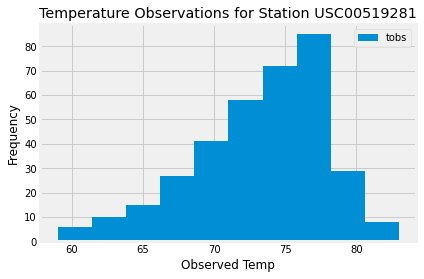

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps= session.query(measurement.station,measurement.tobs).\
        filter(measurement.station == most_active).\
        filter(measurement.date>= one_year_ago).all()
tempsdf= pd.DataFrame(temps)
tempsdf.head()

tempsdf.plot.hist(by="station")
plt.title("Temperature Observations for Station " + most_active)
plt.xlabel("Observed Temp")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("Resources/stationtemps.png", bbox_inches='tight')


# Close session

In [42]:
# Close Session
session.close()